# Couple candlestick - Analytics

In [103]:
# the last one of 2 candlesticks is shaven head or shaven bottom

### Import Library

In [104]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [105]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [106]:
data = dataset.copy()

In [107]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2020-11-01 00:00:00']

In [108]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if 100 * r.name.hour + r.name.minute >= 1425:
        return signal
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [109]:
# Couple candlesticks signal
data['low_s1'] = data['Low'].shift(1)
data['high_s1'] = data['High'].shift(1)
data['max_5'] = data['High'].rolling(5).max()
data['min_5'] = data['Low'].rolling(5).min()
data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
data['condition_1'] = data['condition_1'].shift(1)
data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
data['signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)

In [110]:
data[data['signal'] != '']

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,condition_2,signal
Date,,,,,,,,,,,,
2020-11-02 10:05:00,900.0,900.4,899.5,899.5,1044,900.0,901.3,901.4,897.7,short,short,short
2020-11-03 09:20:00,908.5,908.8,908.1,908.1,847,908.3,908.9,909.4,908.1,short,short,short
2020-11-04 09:35:00,907.8,908.0,907.3,907.3,1361,907.5,908.4,908.8,907.3,short,short,short
2020-11-04 10:05:00,908.2,909.0,908.1,909.0,1800,907.9,908.6,909.0,906.8,long,long,long
2020-11-04 10:15:00,910.2,911.5,909.8,911.5,3514,909.1,910.5,911.5,907.6,long,long,long
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26 09:30:00,1347.3,1348.4,1346.4,1348.4,2770,1346.4,1347.4,1348.4,1346.2,long,long,long
2024-09-26 09:40:00,1348.6,1350.9,1348.1,1350.9,6468,1347.8,1348.9,1350.9,1346.2,long,long,long
2024-09-26 14:15:00,1363.1,1364.3,1360.1,1360.1,7694,1362.6,1365.5,1366.5,1360.1,short,short,short


## Trap labeling

In [111]:
traps = []
for i, row in data.iterrows():
    if row['signal']:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
        if not len(data_to_end_day):
            traps.append(1)
            continue
        #
        if row['signal'] == 'short':
            if len(data_to_end_day[data_to_end_day.High > row['Close'] + 3.5]) > 0:
                traps.append(1)
            else:
                traps.append(0)
        else:
            if len(data_to_end_day[data_to_end_day.Low < row['Close'] - 3.5]) > 0:
                traps.append(1)
            else:
                traps.append(0)
    else:
        traps.append(0)

In [112]:
data['trap'] = traps

In [113]:
data[data.trap != 0]

,Open,High,Low,Close,Volume,low_s1,high_s1,max_5,min_5,condition_1,condition_2,signal,trap
Date,,,,,,,,,,,,,
2020-11-02 10:05:00,900.0,900.4,899.5,899.5,1044,900.0,901.3,901.4,897.7,short,short,short,1
2020-11-04 09:35:00,907.8,908.0,907.3,907.3,1361,907.5,908.4,908.8,907.3,short,short,short,1
2020-11-04 11:00:00,913.5,914.2,912.8,914.2,1996,913.0,913.7,914.3,912.3,long,long,long,1
2020-11-10 10:30:00,929.3,930.0,929.2,930.0,1369,928.6,929.5,931.1,928.1,long,long,long,1
2020-11-11 10:50:00,921.4,921.9,920.9,921.9,1331,920.8,921.6,921.9,919.4,long,long,long,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-19 09:25:00,1314.0,1314.2,1313.4,1313.4,2162,1313.5,1315.7,1315.7,1312.6,short,short,short,1
2024-09-23 09:10:00,1331.2,1331.9,1331.2,1331.9,1468,1330.7,1331.4,1331.9,1330.0,long,long,long,1
2024-09-25 10:10:00,1341.3,1341.6,1340.6,1340.6,1526,1341.0,1342.0,1343.3,1339.5,short,short,short,1


In [114]:
real_signal_rate = len(data[(data.signal != '') & (data.trap == 0)]) / len(data[data.signal != ''])
real_signal_rate

0.42006886374815544

## Analytics

In [115]:
data['RSI'] = ta.rsi(data["Close"], length=14)
data['RSI'] = round(data['RSI'])
data["ATR"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
adx42 = ta.adx(data['High'], data['Low'], data['Close'], length=42)
adx5 = ta.adx(data['High'], data['Low'], data['Close'], length=5)
data = data.assign(ADX42=adx42['ADX_42'])
data = data.assign(ADX5=adx5['ADX_5'])
macd = ta.macd(data['Close'], 26, 12, 9)
data = data.assign(MACDh=macd['MACDh_12_26_9']).rename(columns={'MACDh_12_26_9': 'MACDh'})    # Histogram

## 11. Distance from Close to EMA_20 & EMA_20 to EMA_250

In [141]:
df11= data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
#
df11["ema_f"] = ta.ema(df11["Close"], length=26)
df11["ema_l"] = ta.ema(df11["Close"], length=250)
df11["distance_1"] = df11["Close"] - df11["ema_f"]
df11["distance_2"] = df11["ema_f"] - df11["ema_l"]
#
signal_data = df11[df11.signal != '']
long_signals = signal_data[signal_data.signal == 'long']
short_signals = signal_data[signal_data.signal == 'short']
trap_signals = signal_data[signal_data.trap == 1]
real_signals = signal_data[signal_data.trap == 0]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

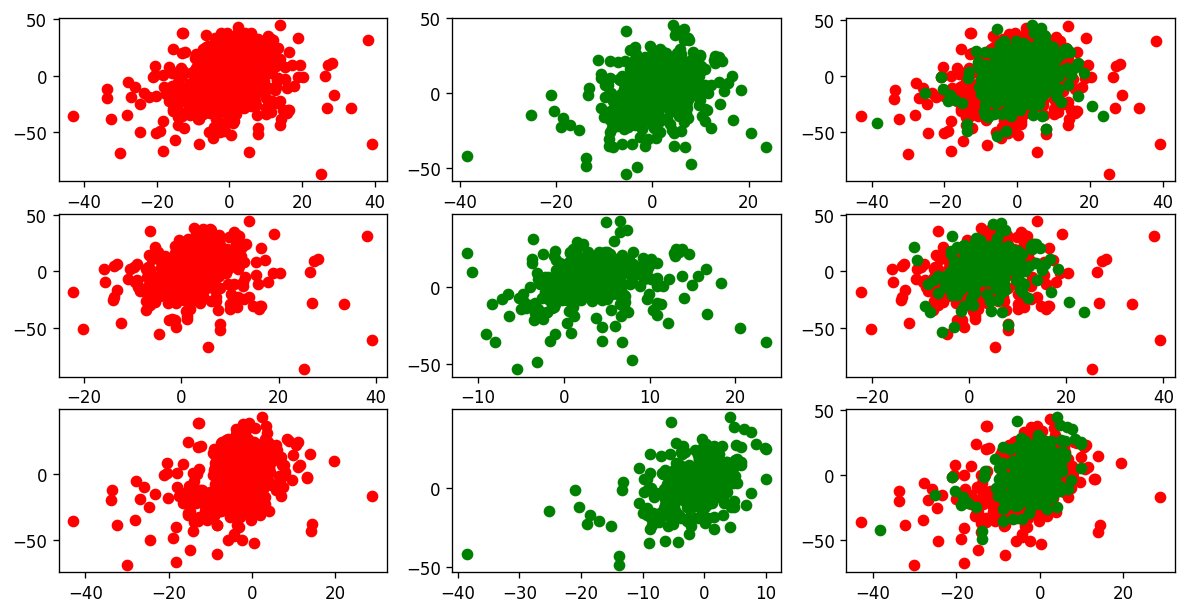

In [142]:
plt.subplot(3, 3, 1)
plt.scatter(trap_signals['distance_1'], trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 2)
plt.scatter(real_signals['distance_1'], real_signals['distance_2'], c='green')
plt.subplot(3, 3, 3)
plt.scatter(trap_signals['distance_1'], trap_signals['distance_2'], c='red')
plt.scatter(real_signals['distance_1'], real_signals['distance_2'], c='green')
#
plt.subplot(3, 3, 4)
plt.scatter(long_trap_signals['distance_1'], long_trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 5)
plt.scatter(long_real_signals['distance_1'], long_real_signals['distance_2'], c='green')
plt.subplot(3, 3, 6)
plt.scatter(long_trap_signals['distance_1'], long_trap_signals['distance_2'], c='red')
plt.scatter(long_real_signals['distance_1'], long_real_signals['distance_2'], c='green')
#
#
plt.subplot(3, 3, 7)
plt.scatter(short_trap_signals['distance_1'], short_trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 8)
plt.scatter(short_real_signals['distance_1'], short_real_signals['distance_2'], c='green')
plt.subplot(3, 3, 9)
plt.scatter(short_trap_signals['distance_1'], short_trap_signals['distance_2'], c='red')
plt.scatter(short_real_signals['distance_1'], short_real_signals['distance_2'], c='green')

## 10. Price move (v2) & ATR & trap relationship

In [138]:
df10 = data[["Open", "Close", "High", "Low", "signal", "ATR", "trap"]].copy()
df10['price_move'] = df10['Close'] - df10['Close'].shift(2)
df10['price_move'] = round(df10['price_move'])
#
signal_data = df10[df10.signal != '']
signal_data.dropna(inplace=True)
long_signals = signal_data[signal_data.signal == 'long']
short_signals = signal_data[signal_data.signal == 'short']
trap_signals = signal_data[signal_data.trap == 1]
real_signals = signal_data[signal_data.trap == 0]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

<Axes: xlabel='price_move'>

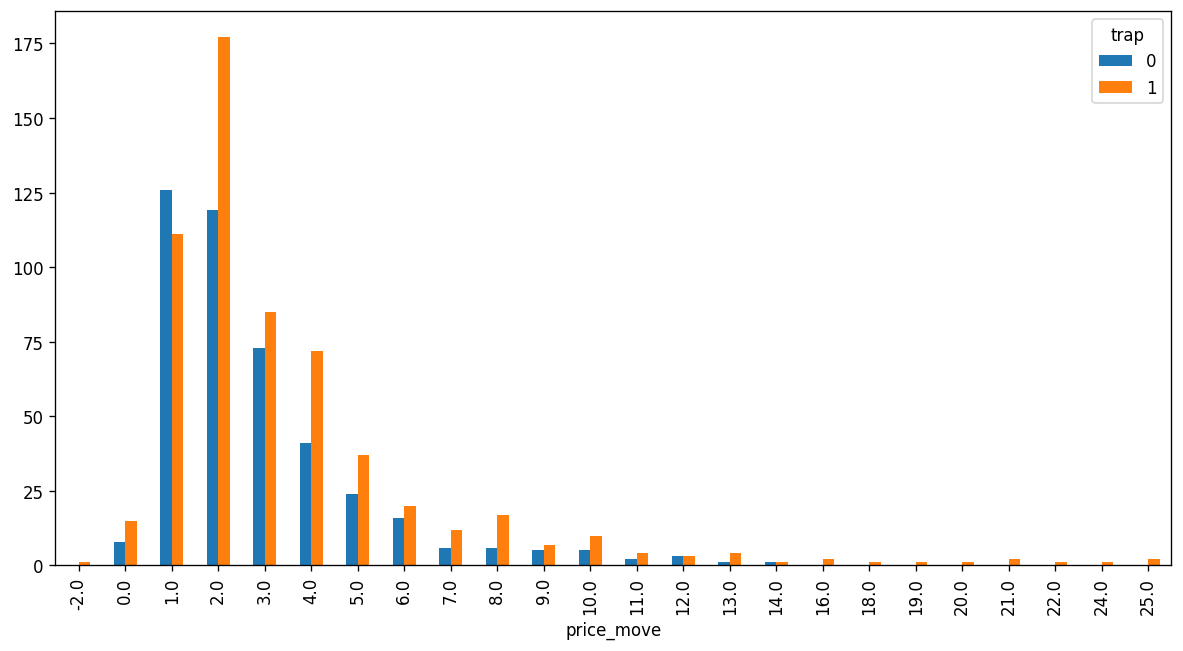

In [139]:
signal_group_by_price_move = signal_data[signal_data.signal == 'long'].groupby(['price_move', 'trap'])['price_move'].count().rename({'price_move': 'count'})
signal_group_by_price_move.unstack().plot.bar()

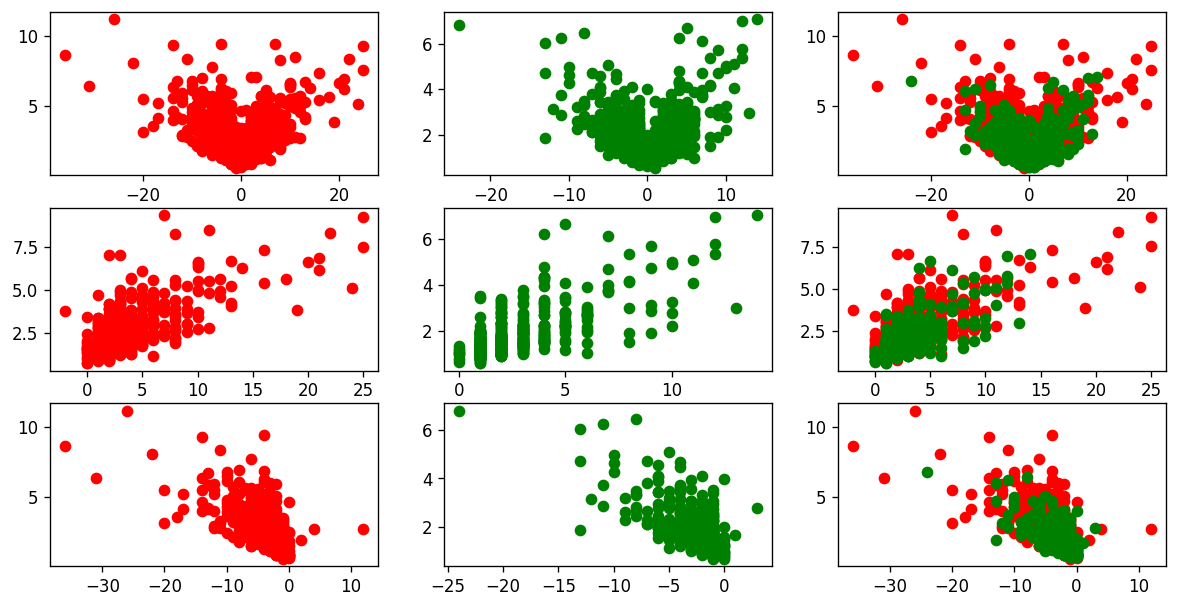

In [140]:
plt.subplot(3, 3, 1)
plt.scatter(trap_signals['price_move'], trap_signals['ATR'], c='red')
plt.subplot(3, 3, 2)
plt.scatter(real_signals['price_move'], real_signals['ATR'], c='green')
plt.subplot(3, 3, 3)
plt.scatter(trap_signals['price_move'], trap_signals['ATR'], c='red')
plt.scatter(real_signals['price_move'], real_signals['ATR'], c='green')
#
plt.subplot(3, 3, 4)
plt.scatter(long_trap_signals['price_move'], long_trap_signals['ATR'], c='red')
plt.subplot(3, 3, 5)
plt.scatter(long_real_signals['price_move'], long_real_signals['ATR'], c='green')
plt.subplot(3, 3, 6)
plt.scatter(long_trap_signals['price_move'], long_trap_signals['ATR'], c='red')
plt.scatter(long_real_signals['price_move'], long_real_signals['ATR'], c='green')
#
#
plt.subplot(3, 3, 7)
plt.scatter(short_trap_signals['price_move'], short_trap_signals['ATR'], c='red')
plt.subplot(3, 3, 8)
plt.scatter(short_real_signals['price_move'], short_real_signals['ATR'], c='green')
plt.subplot(3, 3, 9)
plt.scatter(short_trap_signals['price_move'], short_trap_signals['ATR'], c='red')
plt.scatter(short_real_signals['price_move'], short_real_signals['ATR'], c='green')

## 9. Distance from Close to EMA_26 & EMA_250

In [124]:
df9= data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
#
df9["ema_f"] = ta.ema(df9["Close"], length=26)
df9["ema_l"] = ta.ema(df9["Close"], length=250)
df9["distance_1"] = df9["Close"] - df9["ema_f"]
df9["distance_2"] = df9["Close"] - df9["ema_l"]
#
signal_data = df9[df9.signal != '']
long_signals = signal_data[signal_data.signal == 'long']
short_signals = signal_data[signal_data.signal == 'short']
trap_signals = signal_data[signal_data.trap == 1]
real_signals = signal_data[signal_data.trap == 0]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

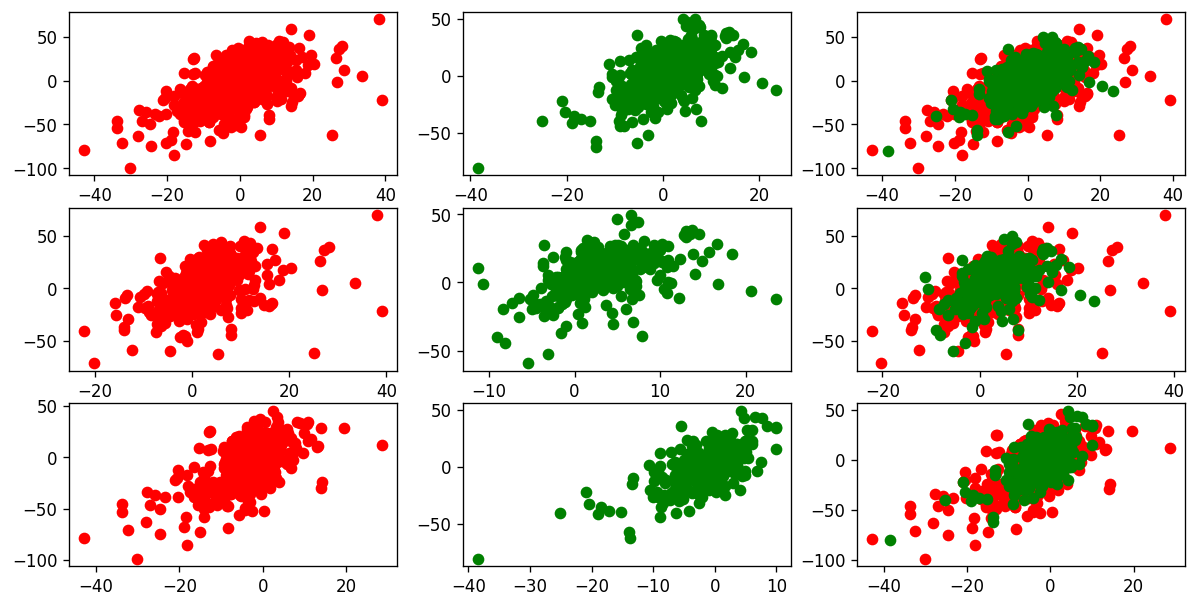

In [125]:
plt.subplot(3, 3, 1)
plt.scatter(trap_signals['distance_1'], trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 2)
plt.scatter(real_signals['distance_1'], real_signals['distance_2'], c='green')
plt.subplot(3, 3, 3)
plt.scatter(trap_signals['distance_1'], trap_signals['distance_2'], c='red')
plt.scatter(real_signals['distance_1'], real_signals['distance_2'], c='green')
#
plt.subplot(3, 3, 4)
plt.scatter(long_trap_signals['distance_1'], long_trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 5)
plt.scatter(long_real_signals['distance_1'], long_real_signals['distance_2'], c='green')
plt.subplot(3, 3, 6)
plt.scatter(long_trap_signals['distance_1'], long_trap_signals['distance_2'], c='red')
plt.scatter(long_real_signals['distance_1'], long_real_signals['distance_2'], c='green')
#
#
plt.subplot(3, 3, 7)
plt.scatter(short_trap_signals['distance_1'], short_trap_signals['distance_2'], c='red')
plt.subplot(3, 3, 8)
plt.scatter(short_real_signals['distance_1'], short_real_signals['distance_2'], c='green')
plt.subplot(3, 3, 9)
plt.scatter(short_trap_signals['distance_1'], short_trap_signals['distance_2'], c='red')
plt.scatter(short_real_signals['distance_1'], short_real_signals['distance_2'], c='green')

## 8. EMAs slope

In [120]:
df8 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
#
df8["ema"] = ta.ema(df8["Close"], length=20)
df8["ema_slope1"] = df8["ema"] - df8["ema"].shift(26)
df8["ema_slope1"] = round(df8["ema_slope1"])
df8["ema_slope2"] = df8["ema"] - df8["ema"].shift(51)
df8["ema_slope2"] = round(df8["ema_slope2"])
#
signal_data = df8[df8.signal != '']
long_signals = signal_data[signal_data.signal == 'long']
short_signals = signal_data[signal_data.signal == 'short']
trap_signals = signal_data[signal_data.trap == 1]
real_signals = signal_data[signal_data.trap == 0]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

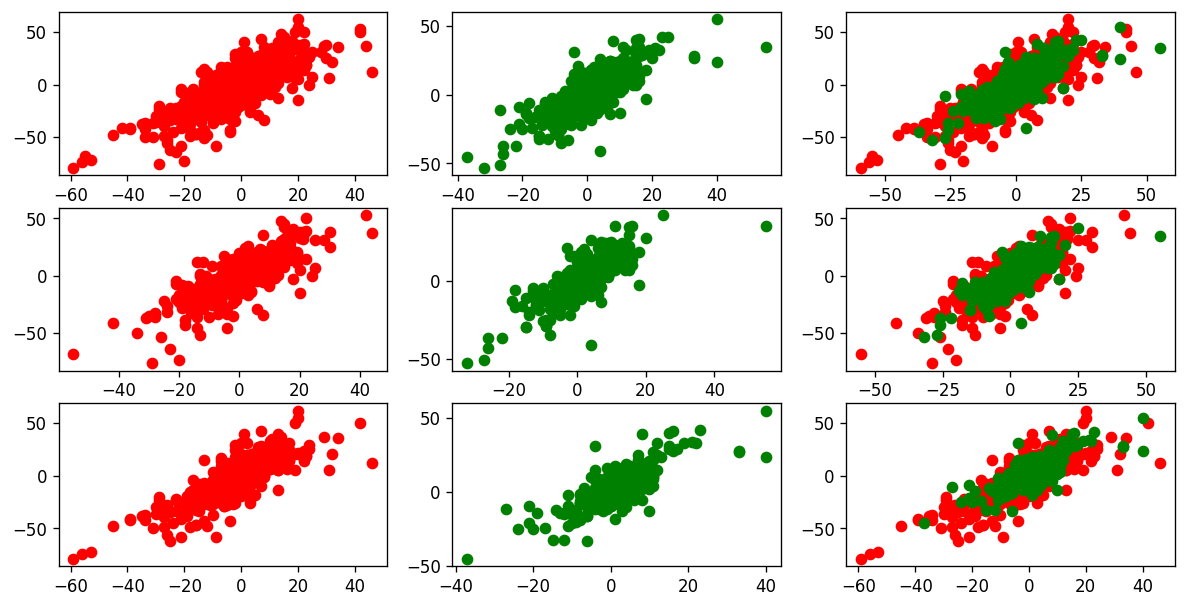

In [121]:
plt.subplot(3, 3, 1)
plt.scatter(trap_signals['ema_slope1'], trap_signals['ema_slope2'], c='red')
plt.subplot(3, 3, 2)
plt.scatter(real_signals['ema_slope1'], real_signals['ema_slope2'], c='green')
plt.subplot(3, 3, 3)
plt.scatter(trap_signals['ema_slope1'], trap_signals['ema_slope2'], c='red')
plt.scatter(real_signals['ema_slope1'], real_signals['ema_slope2'], c='green')
#
plt.subplot(3, 3, 4)
plt.scatter(long_trap_signals['ema_slope1'], long_trap_signals['ema_slope2'], c='red')
plt.subplot(3, 3, 5)
plt.scatter(long_real_signals['ema_slope1'], long_real_signals['ema_slope2'], c='green')
plt.subplot(3, 3, 6)
plt.scatter(long_trap_signals['ema_slope1'], long_trap_signals['ema_slope2'], c='red')
plt.scatter(long_real_signals['ema_slope1'], long_real_signals['ema_slope2'], c='green')
#
#
plt.subplot(3, 3, 7)
plt.scatter(short_trap_signals['ema_slope1'], short_trap_signals['ema_slope2'], c='red')
plt.subplot(3, 3, 8)
plt.scatter(short_real_signals['ema_slope1'], short_real_signals['ema_slope2'], c='green')
plt.subplot(3, 3, 9)
plt.scatter(short_trap_signals['ema_slope1'], short_trap_signals['ema_slope2'], c='red')
plt.scatter(short_real_signals['ema_slope1'], short_real_signals['ema_slope2'], c='green')

<Axes: xlabel='ema_slope1'>

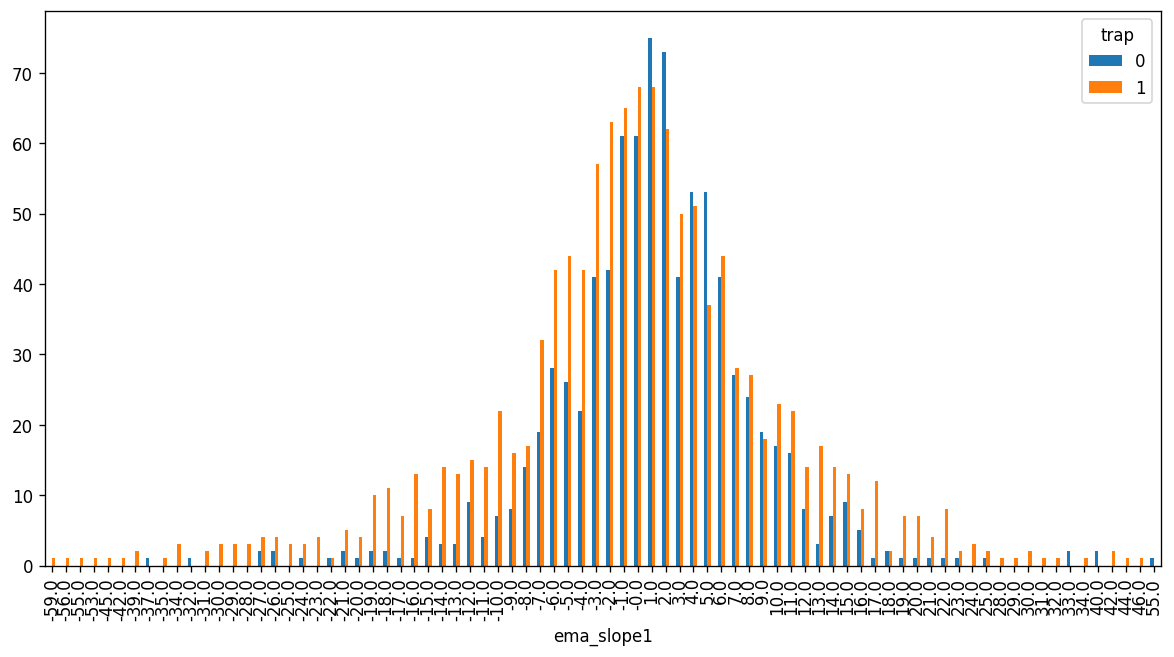

In [122]:
signal_group_by_ema_slope = signal_data.groupby(['ema_slope1', 'trap'])['ema_slope1'].count().rename({'ema_slope1': 'count'})
signal_group_by_ema_slope.unstack().plot.bar()

## 7. Time & couple_bars strength & trap relationship

In [69]:
df7 = data[["Open", "Close", "High", "Low", "signal", "trap"]].copy()
# couple bars strength = ((high - open) + (high - close)) / (2 * (high - low))
df7['couple_bars_strength'] = (2 * df7['Close'] - df7['Open'].shift(1) - df7['Close'].shift(1)) / (2 * df7['Close'] - 2 * df7['Low'].shift(1))
signal_data = df7[df7.signal != '']
signal_data['time_hm'] = 100 * signal_data.index.hour + signal_data.index.minute
trap_signals = signal_data[signal_data.trap == 1]
real_signals = signal_data[signal_data.trap == 0]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

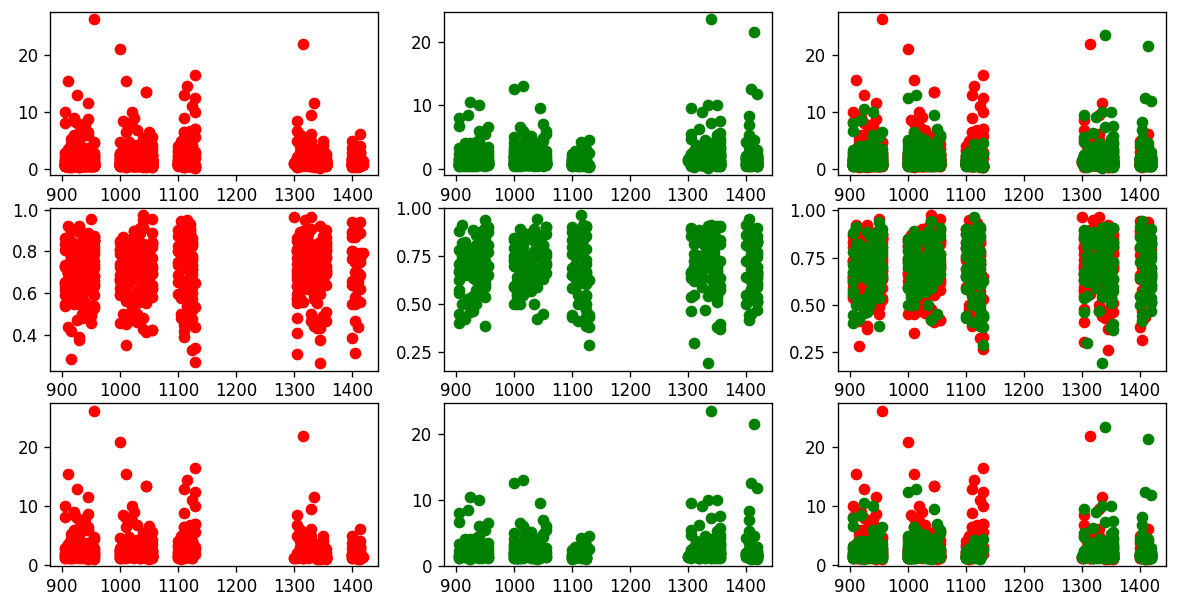

In [70]:
plt.subplot(3, 3, 1)
plt.scatter(trap_signals['time_hm'], trap_signals['couple_bars_strength'], c='red')
plt.subplot(3, 3, 2)
plt.scatter(real_signals['time_hm'], real_signals['couple_bars_strength'], c='green')
plt.subplot(3, 3, 3)
plt.scatter(trap_signals['time_hm'], trap_signals['couple_bars_strength'], c='red')
plt.scatter(real_signals['time_hm'], real_signals['couple_bars_strength'], c='green')
#
plt.subplot(3, 3, 4)
plt.scatter(long_trap_signals['time_hm'], long_trap_signals['couple_bars_strength'], c='red')
plt.subplot(3, 3, 5)
plt.scatter(long_real_signals['time_hm'], long_real_signals['couple_bars_strength'], c='green')
plt.subplot(3, 3, 6)
plt.scatter(long_trap_signals['time_hm'], long_trap_signals['couple_bars_strength'], c='red')
plt.scatter(long_real_signals['time_hm'], long_real_signals['couple_bars_strength'], c='green')
#
#
plt.subplot(3, 3, 7)
plt.scatter(short_trap_signals['time_hm'], short_trap_signals['couple_bars_strength'], c='red')
plt.subplot(3, 3, 8)
plt.scatter(short_real_signals['time_hm'], short_real_signals['couple_bars_strength'], c='green')
plt.subplot(3, 3, 9)
plt.scatter(short_trap_signals['time_hm'], short_trap_signals['couple_bars_strength'], c='red')
plt.scatter(short_real_signals['time_hm'], short_real_signals['couple_bars_strength'], c='green')

<Axes: xlabel='couple_bars_strength'>

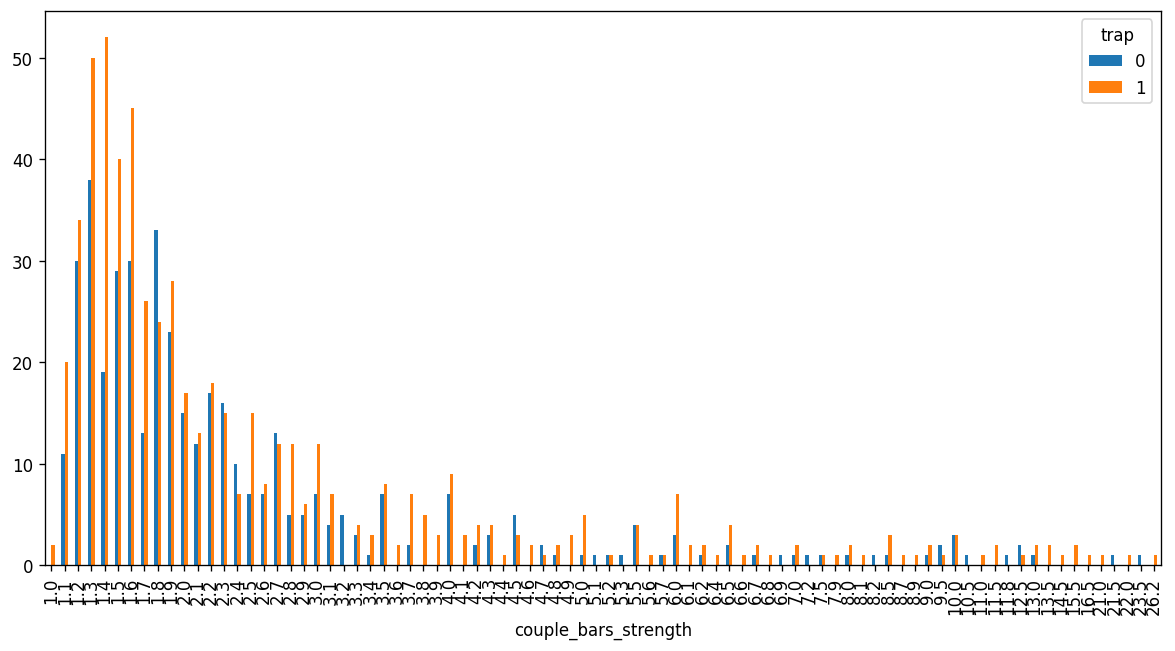

In [71]:
signal_data['couple_bars_strength'] = round(signal_data['couple_bars_strength'], 1)
signal_group_by_2bars_strength = signal_data[signal_data.signal == 'short'].groupby(['couple_bars_strength', 'trap'])['couple_bars_strength'].count().rename({'couple_bars_strength': 'count'})
signal_group_by_2bars_strength.unstack().plot.bar()

<Axes: xlabel='couple_bars_strength'>

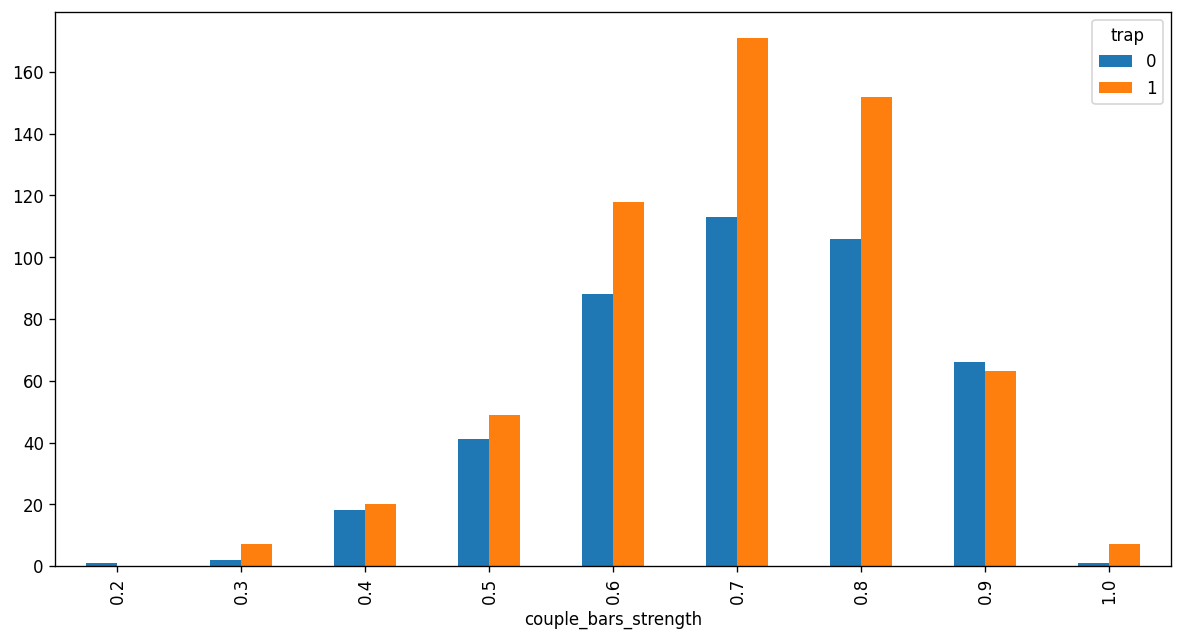

In [72]:
lsignal_group_by_2bars_strength = signal_data[signal_data.signal == 'long'].groupby(['couple_bars_strength', 'trap'])['couple_bars_strength'].count().rename({'couple_bars_strength': 'count'})
lsignal_group_by_2bars_strength.unstack().plot.bar()

## 6. Trend strength & MACD momentum & trap relationship

In [73]:
df6 = data[["Open", "Close", "High", "Low", "signal", "MACDh", "ADX42", "trap"]].copy()
signal_data = df6[df6.signal != '']
trap_signals = signal_data[signal_data.trap == 1]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
real_signals = signal_data[signal_data.trap == 0]
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

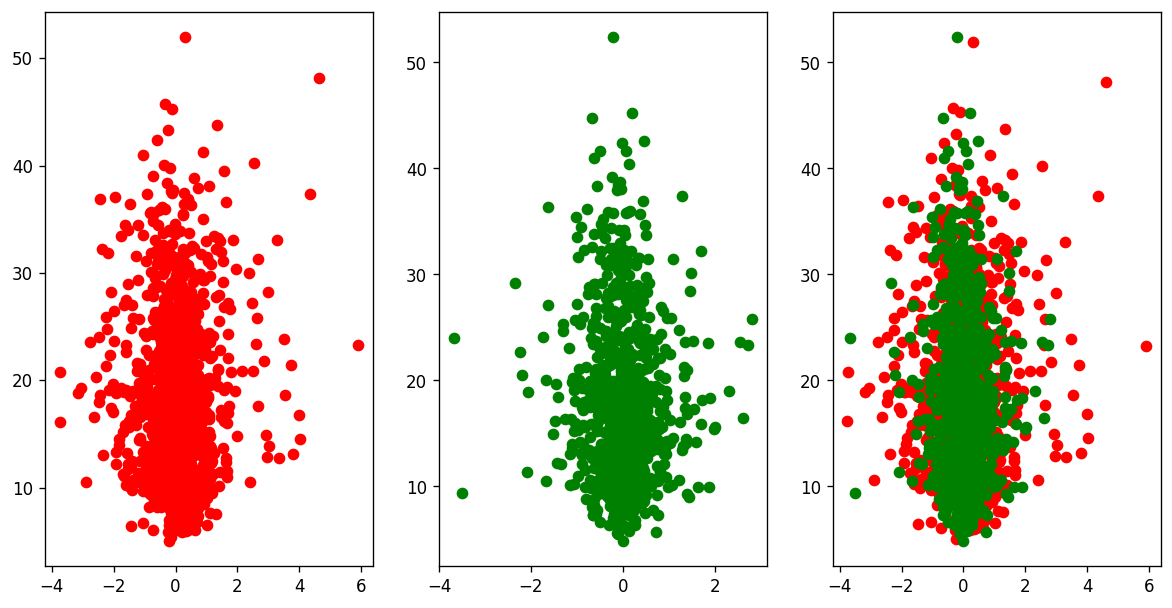

In [74]:
plt.subplot(1, 3, 1)
plt.scatter(trap_signals['MACDh'], trap_signals['ADX42'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(real_signals['MACDh'], real_signals['ADX42'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(trap_signals['MACDh'], trap_signals['ADX42'], c='red')
plt.scatter(real_signals['MACDh'], real_signals['ADX42'], c='green')

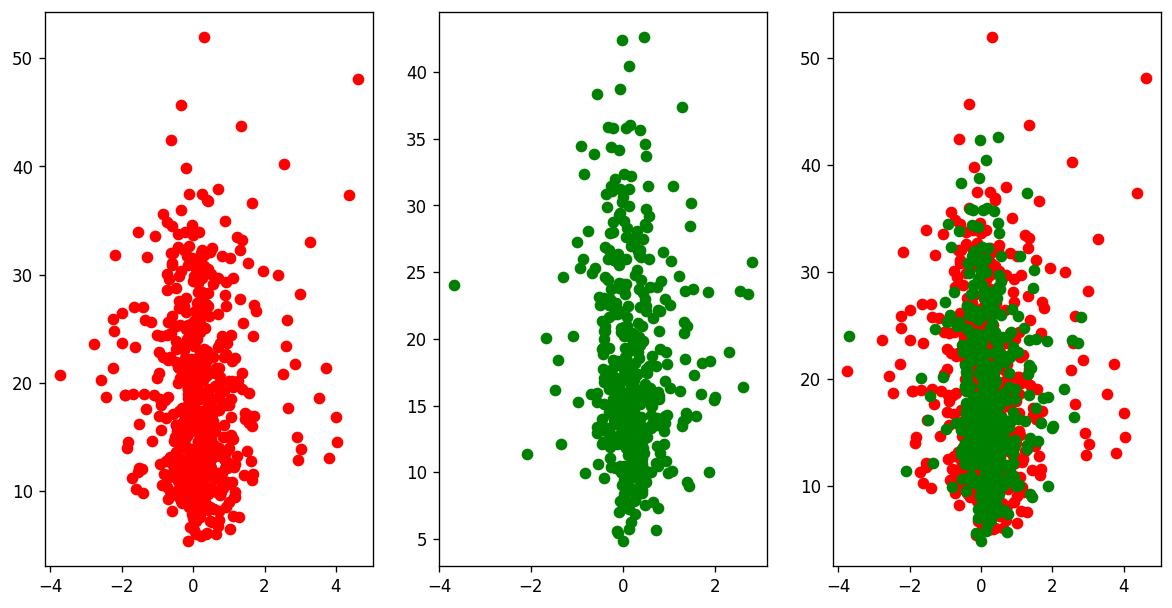

In [75]:
plt.subplot(1, 3, 1)
plt.scatter(long_trap_signals['MACDh'], long_trap_signals['ADX42'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(long_real_signals['MACDh'], long_real_signals['ADX42'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(long_trap_signals['MACDh'], long_trap_signals['ADX42'], c='red')
plt.scatter(long_real_signals['MACDh'], long_real_signals['ADX42'], c='green')

## 5. Trend strength ADX & trap relationship

In [76]:
df5 = data[["Open", "Close", "High", "Low", "signal", "ADX5", "ADX42", "trap"]].copy()
signal_data = df5[df5.signal != '']
trap_signals = signal_data[signal_data.trap == 1]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
real_signals = signal_data[signal_data.trap == 0]
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

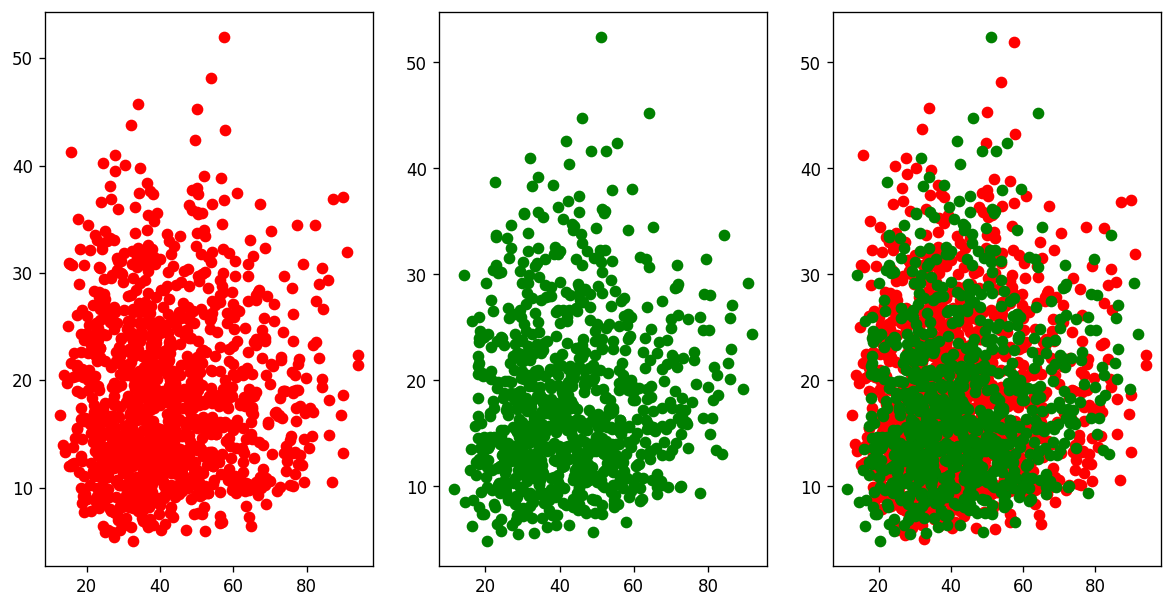

In [77]:
plt.subplot(1, 3, 1)
plt.scatter(trap_signals['ADX5'], trap_signals['ADX42'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(real_signals['ADX5'], real_signals['ADX42'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(trap_signals['ADX5'], trap_signals['ADX42'], c='red')
plt.scatter(real_signals['ADX5'], real_signals['ADX42'], c='green')

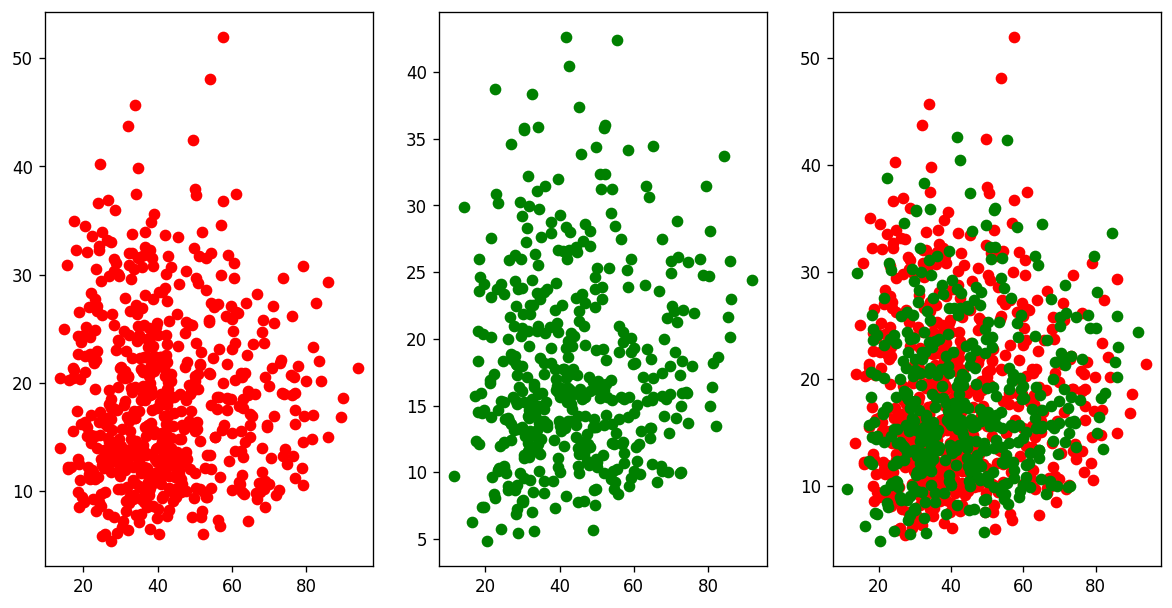

In [78]:
plt.subplot(1, 3, 1)
plt.scatter(long_trap_signals['ADX5'], long_trap_signals['ADX42'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(long_real_signals['ADX5'], long_real_signals['ADX42'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(long_trap_signals['ADX5'], long_trap_signals['ADX42'], c='red')
plt.scatter(long_real_signals['ADX5'], long_real_signals['ADX42'], c='green')

## 4. Price move & ATR & trap relationship

In [79]:
df4 = data[["Open", "Close", "High", "Low", "signal", "ATR", "trap"]].copy()
df4['price_move'] = df4['Close'] - df4['Close'].shift(1)
signal_data = df4[df4.signal != '']
trap_signals = signal_data[signal_data.trap == 1]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
real_signals = signal_data[signal_data.trap == 0]
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

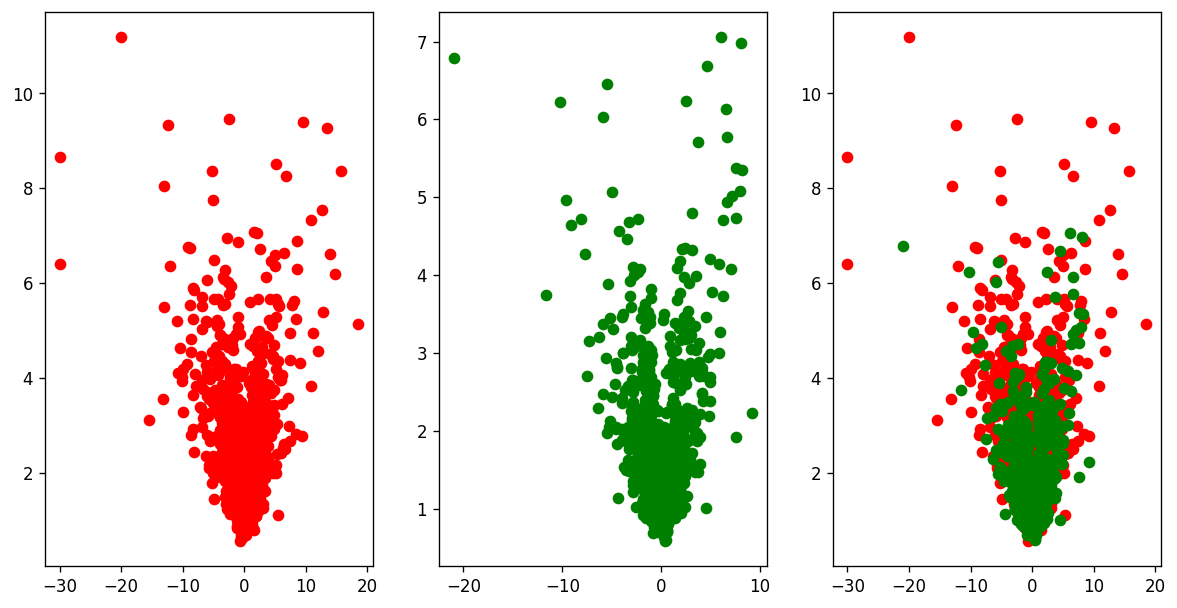

In [80]:
plt.subplot(1, 3, 1)
plt.scatter(trap_signals['price_move'], trap_signals['ATR'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(real_signals['price_move'], real_signals['ATR'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(trap_signals['price_move'], trap_signals['ATR'], c='red')
plt.scatter(real_signals['price_move'], real_signals['ATR'], c='green')

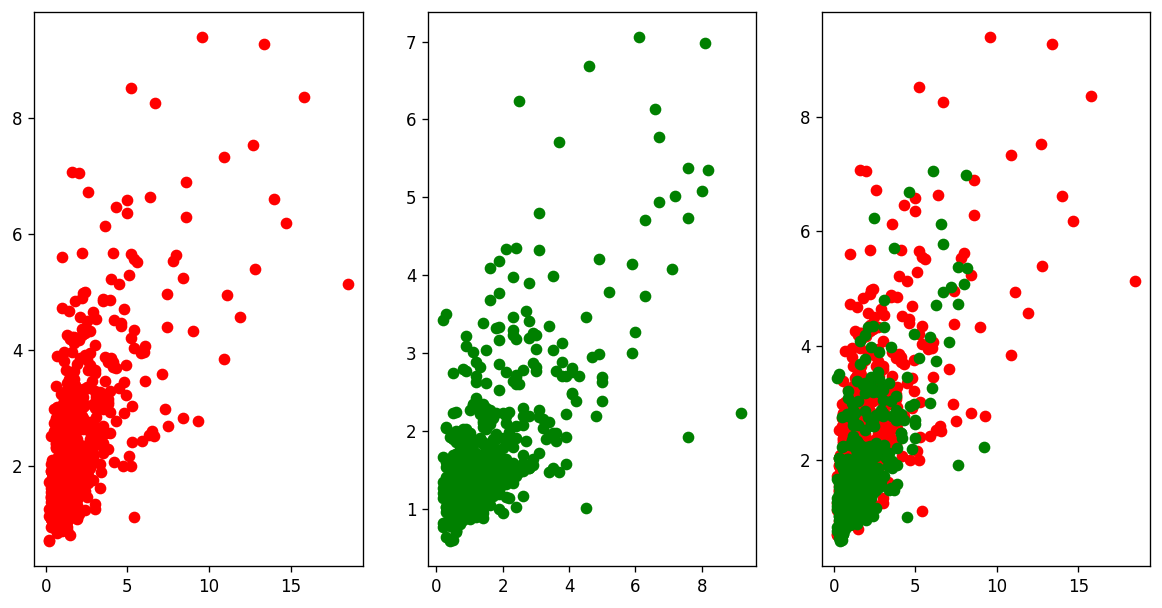

In [81]:
plt.subplot(1, 3, 1)
plt.scatter(long_trap_signals['price_move'], long_trap_signals['ATR'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(long_real_signals['price_move'], long_real_signals['ATR'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(long_trap_signals['price_move'], long_trap_signals['ATR'], c='red')
plt.scatter(long_real_signals['price_move'], long_real_signals['ATR'], c='green')

## 3. Min-Max last 20 & current price & trap relationship

In [82]:
df1 = data[["Open", "Close", "High", "Low", "signal", "RSI", "trap"]].copy()
df1['max_close20'] = df1['Close'].rolling(20).max()
df1['min_close20'] = df1['Close'].rolling(20).min()
df1['diff_to_max'] = df1['Close'] / df1['max_close20']
df1['diff_to_max'] = round(df1['diff_to_max'], 3)
df1['diff_to_min'] = df1['Close'] / df1['min_close20']
df1['diff_to_min'] = round(df1['diff_to_min'], 3)
signal_data = df1[df1.signal != '']
trap_signals = signal_data[signal_data.trap == 1]
long_trap_signals = trap_signals[trap_signals.signal == 'long']
short_trap_signals = trap_signals[trap_signals.signal == 'short']
real_signals = signal_data[signal_data.trap == 0]
long_real_signals = real_signals[real_signals.signal == 'long']
short_real_signals = real_signals[real_signals.signal == 'short']

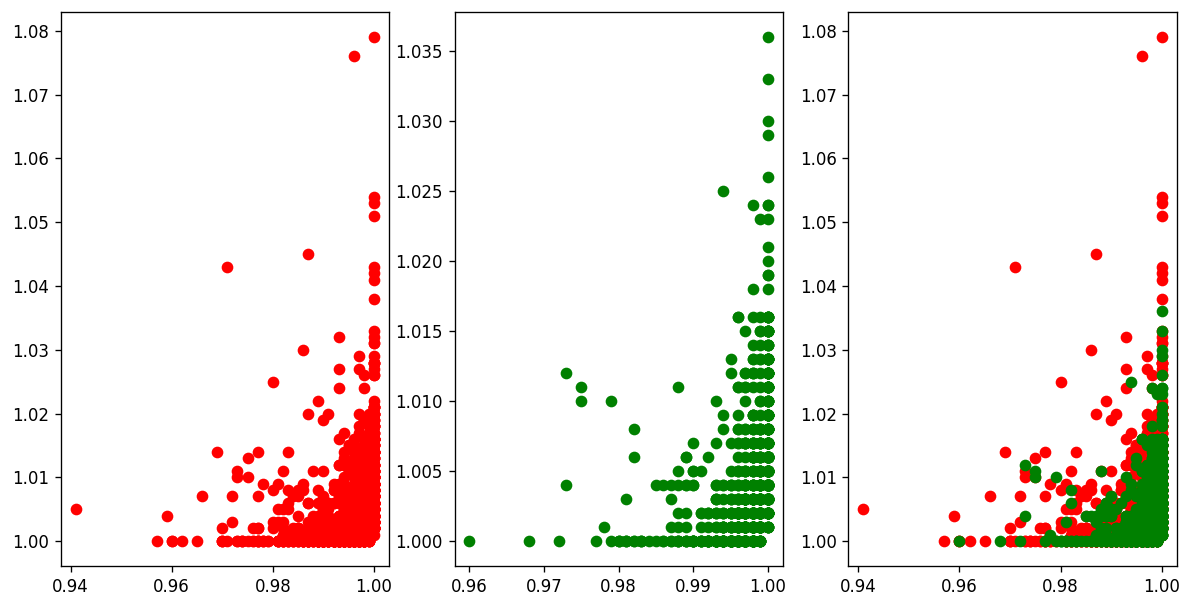

In [83]:
plt.subplot(1, 3, 1)
plt.scatter(trap_signals['diff_to_max'], trap_signals['diff_to_min'], c='red')
plt.subplot(1, 3, 2)
plt.scatter(real_signals['diff_to_max'], real_signals['diff_to_min'], c='green')
plt.subplot(1, 3, 3)
plt.scatter(trap_signals['diff_to_max'], trap_signals['diff_to_min'], c='red')
plt.scatter(real_signals['diff_to_max'], real_signals['diff_to_min'], c='green')

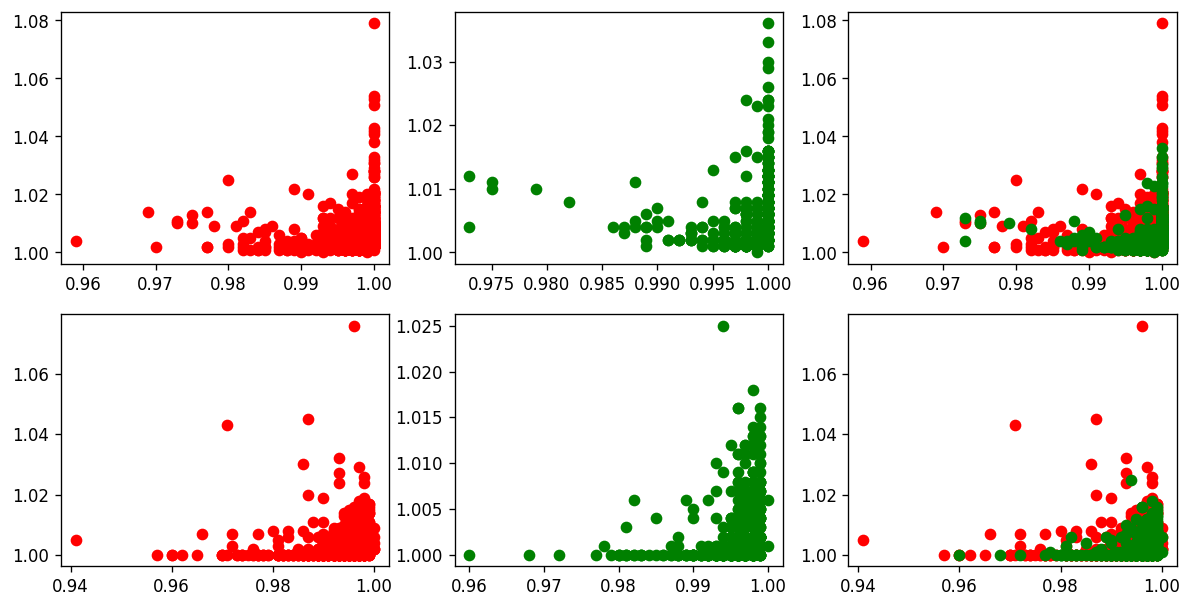

In [84]:
plt.subplot(2, 3, 1)
plt.scatter(long_trap_signals['diff_to_max'], long_trap_signals['diff_to_min'], c='red')
plt.subplot(2, 3, 2)
plt.scatter(long_real_signals['diff_to_max'], long_real_signals['diff_to_min'], c='green')
plt.subplot(2, 3, 3)
plt.scatter(long_trap_signals['diff_to_max'], long_trap_signals['diff_to_min'], c='red')
plt.scatter(long_real_signals['diff_to_max'], long_real_signals['diff_to_min'], c='green')
plt.subplot(2, 3, 4)
plt.scatter(short_trap_signals['diff_to_max'], short_trap_signals['diff_to_min'], c='red')
plt.subplot(2, 3, 5)
plt.scatter(short_real_signals['diff_to_max'], short_real_signals['diff_to_min'], c='green')
plt.subplot(2, 3, 6)
plt.scatter(short_trap_signals['diff_to_max'], short_trap_signals['diff_to_min'], c='red')
plt.scatter(short_real_signals['diff_to_max'], short_real_signals['diff_to_min'], c='green')

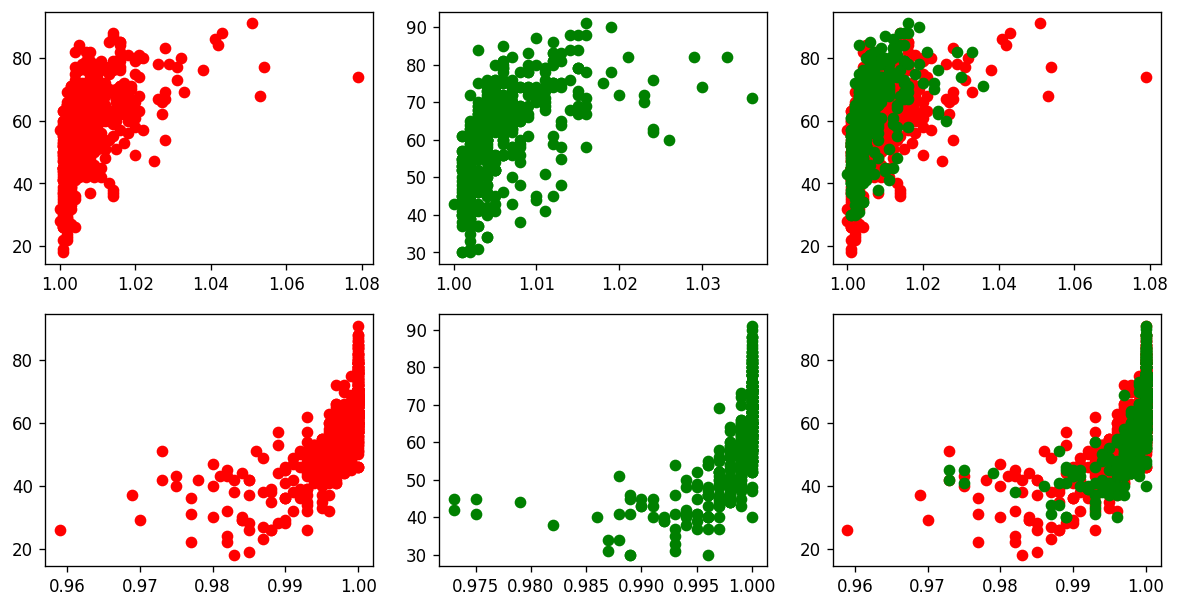

In [85]:
plt.subplot(2, 3, 1)
plt.scatter(long_trap_signals['diff_to_min'], long_trap_signals['RSI'], c='red')
plt.subplot(2, 3, 2)
plt.scatter(long_real_signals['diff_to_min'], long_real_signals['RSI'], c='green')
plt.subplot(2, 3, 3)
plt.scatter(long_trap_signals['diff_to_min'], long_trap_signals['RSI'], c='red')
plt.scatter(long_real_signals['diff_to_min'], long_real_signals['RSI'], c='green')
plt.subplot(2, 3, 4)
plt.scatter(long_trap_signals['diff_to_max'], long_trap_signals['RSI'], c='red')
plt.subplot(2, 3, 5)
plt.scatter(long_real_signals['diff_to_max'], long_real_signals['RSI'], c='green')
plt.subplot(2, 3, 6)
plt.scatter(long_trap_signals['diff_to_max'], long_trap_signals['RSI'], c='red')
plt.scatter(long_real_signals['diff_to_max'], long_real_signals['RSI'], c='green')

## 2. Divergence RSI & trap relationship visualize

In [86]:
df2 = data[["Open", "Close", "High", "Low", "signal", "RSI", "trap"]].copy()
# Identify Lower Low (LL) and Higher RSI
df2['LL'] = df2['Low'] < df2['Low'].shift(1).rolling(20).min() - 0.1
df2['Higher_RSI'] = df2['RSI'] > df2['RSI'].shift(1).rolling(20).min()
# Find divergence signals
df2['bullish_signal'] = df2.apply(lambda r: 1 if r['LL'] & r['Higher_RSI'] else 0, axis=1)
# Identify Higher High (HH) and Lower RSI
df2['HH'] = df2['High'] > df2['High'].shift(1).rolling(20).max() + 0.1
df2['Lower_RSI'] = df2['RSI'] < df2['RSI'].shift(1).rolling(20).max()
# Find divergence signals
df2['bearish_signal'] = df2.apply(lambda r: 1 if r['HH'] & r['Lower_RSI'] else 0, axis=1)
# Bullish Fair Value Gap: Previous High < Next Low (Upward imbalance)
df2["Bullish_FVG"] = df2["High"].shift(2) < df2["Low"]
df2['Bullish_FVG'] = df2.apply(lambda r: 1 if r['Bullish_FVG'] else 0, axis=1)
# Bearish Fair Value Gap: Previous Low > Next High (Downward imbalance)
df2["Bearish_FVG"] = df2["Low"].shift(2) > df2["High"]
df2['Bullish_FVG'] = df2.apply(lambda r: 1 if r['Bearish_FVG'] else 0, axis=1)
df2.dropna(inplace=True)
df2['pass_bearish_signal'] = df2['bearish_signal'].rolling(10).sum()
df2['pass_bullish_signal'] = df2['bullish_signal'].rolling(10).sum()
df2['pass_bearish_fvg'] = df2['Bearish_FVG'].rolling(10).sum()
df2['pass_bullish_fvg'] = df2['Bullish_FVG'].rolling(10).sum()
signal_data = df2[df2.signal != '']
long_signals = signal_data[signal_data.signal == 'long']
long_trap_signals = long_signals[long_signals.trap == 1]
long_real_signals = long_signals[long_signals.trap == 0]
short_signals = signal_data[signal_data.signal == 'short']

<Axes: xlabel='RSI'>

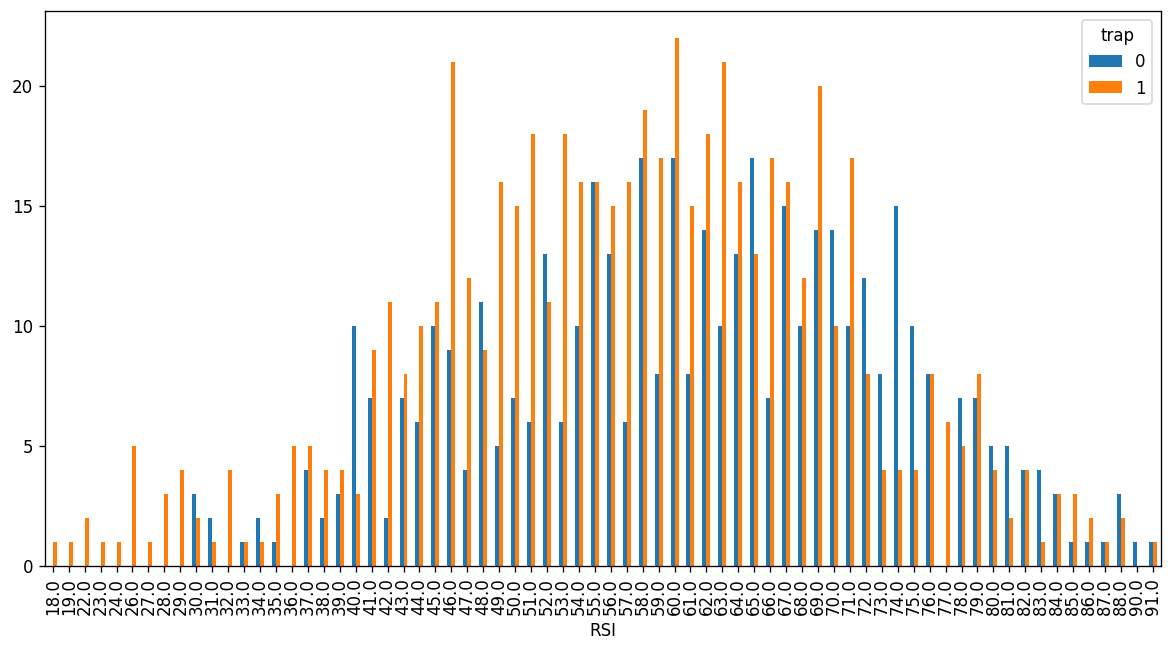

In [87]:
long_group_by_rsi = long_signals.groupby(['RSI', 'trap'])['RSI'].count().rename({'RSI': 'count'})
long_group_by_rsi.unstack().plot.bar()

<Axes: xlabel='RSI'>

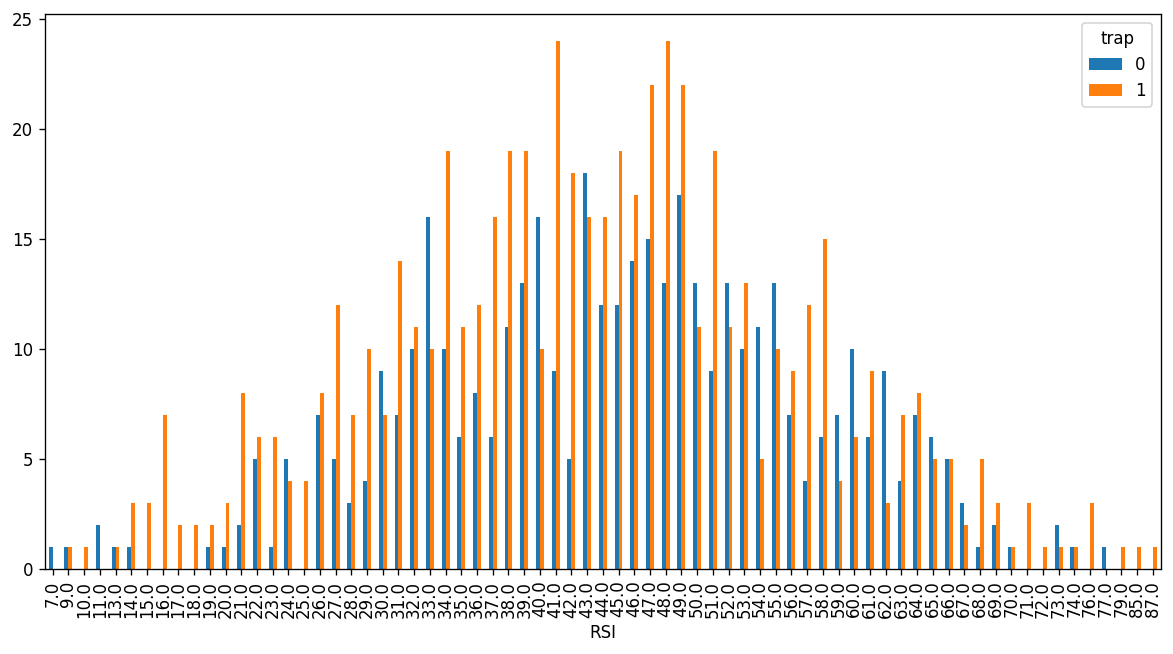

In [88]:
short_group_by_rsi = short_signals.groupby(['RSI', 'trap'])['RSI'].count().rename({'RSI': 'count'})
short_group_by_rsi.unstack().plot.bar()

<Axes: xlabel='RSI'>

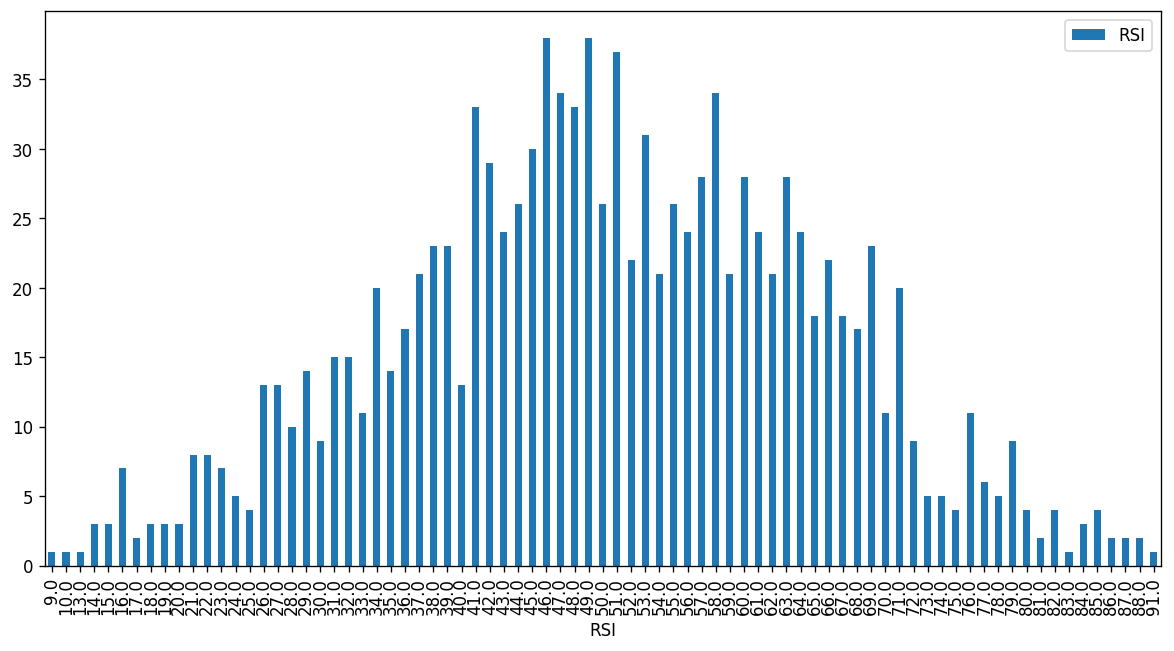

In [89]:
trap_data_grouped_by_rsi = signal_data[signal_data.trap == 1].groupby(['RSI'])[['RSI']].count()
trap_data_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

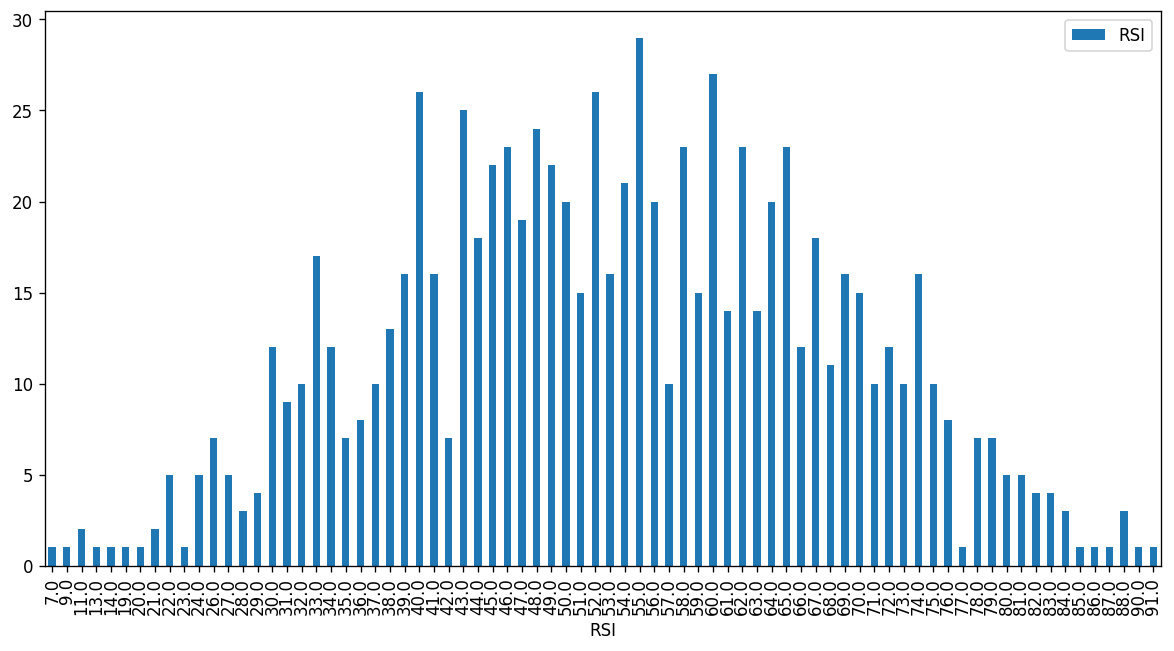

In [90]:
real_data_grouped_by_rsi = signal_data[signal_data.trap == 0].groupby(['RSI'])[['RSI']].count()
real_data_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI'>

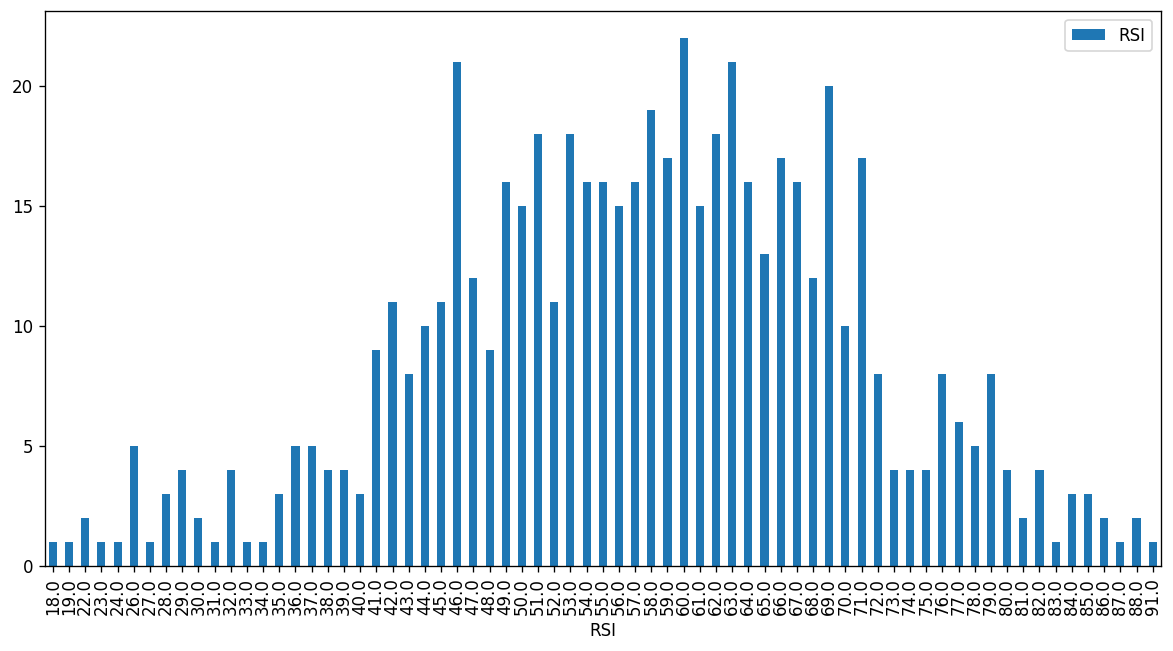

In [91]:
ltrap_data_grouped_by_rsi = long_trap_signals.groupby(['RSI'])[['RSI']].count()
ltrap_data_grouped_by_rsi.plot.bar()

In [92]:
# Long Trap
long_trap_signals[(long_trap_signals.pass_bullish_signal > 0) | (long_trap_signals.pass_bullish_fvg > 0)]

,Open,Close,High,Low,signal,RSI,trap,LL,Higher_RSI,bullish_signal,HH,Lower_RSI,bearish_signal,Bullish_FVG,Bearish_FVG,pass_bearish_signal,pass_bullish_signal,pass_bearish_fvg,pass_bullish_fvg
Date,,,,,,,,,,,,,,,,,,,
2020-11-10 10:30:00,929.3,930.0,930.0,929.2,long,60.0,1,False,True,0,False,True,0,0,False,0.0,0.0,3.0,3.0
2020-11-11 10:50:00,921.4,921.9,921.9,920.9,long,46.0,1,False,True,0,False,False,0,0,False,0.0,1.0,0.0,0.0
2020-11-18 09:30:00,937.4,938.7,938.7,937.3,long,79.0,1,False,True,0,False,True,0,0,False,2.0,0.0,1.0,1.0
2020-11-20 09:55:00,948.0,948.8,948.8,947.8,long,64.0,1,False,True,0,False,True,0,0,False,0.0,0.0,2.0,2.0
2020-11-27 13:30:00,971.6,973.0,973.0,971.3,long,58.0,1,False,True,0,False,True,0,0,False,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-22 09:35:00,1314.8,1315.8,1315.8,1314.2,long,72.0,1,False,True,0,False,True,0,0,False,2.0,0.0,3.0,3.0
2024-09-04 09:15:00,1312.1,1313.7,1313.7,1312.0,long,19.0,1,False,True,0,False,True,0,0,False,0.0,0.0,3.0,3.0
2024-09-10 09:50:00,1310.7,1311.1,1311.1,1310.1,long,64.0,1,False,True,0,False,True,0,0,False,0.0,0.0,1.0,1.0


In [93]:
# Real Long Signal
long_real_signals[(long_real_signals.pass_bullish_signal > 0) | (long_real_signals.pass_bullish_fvg == 0)]

,Open,Close,High,Low,signal,RSI,trap,LL,Higher_RSI,bullish_signal,HH,Lower_RSI,bearish_signal,Bullish_FVG,Bearish_FVG,pass_bearish_signal,pass_bullish_signal,pass_bearish_fvg,pass_bullish_fvg
Date,,,,,,,,,,,,,,,,,,,
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,long,58.0,0,False,True,0,False,True,0,0,False,0.0,0.0,0.0,0.0
2020-11-04 10:15:00,910.2,911.5,911.5,909.8,long,69.0,0,False,True,0,True,False,0,0,False,0.0,0.0,0.0,0.0
2020-11-04 10:35:00,911.2,912.5,912.5,910.8,long,69.0,0,False,True,0,True,False,0,0,False,1.0,0.0,0.0,0.0
2020-11-06 13:40:00,904.5,906.7,906.7,904.4,long,46.0,0,False,True,0,False,False,0,0,False,0.0,1.0,1.0,1.0
2020-11-13 11:30:00,929.0,929.1,929.1,929.0,long,61.0,0,False,True,0,False,True,0,0,False,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-19 09:15:00,1314.6,1315.5,1315.5,1314.2,long,63.0,0,False,True,0,True,True,1,0,False,1.0,1.0,0.0,0.0
2024-09-24 11:15:00,1323.5,1323.7,1323.7,1322.9,long,37.0,0,False,True,0,False,True,0,0,False,0.0,2.0,2.0,2.0
2024-09-25 09:10:00,1337.8,1339.2,1339.2,1337.3,long,87.0,0,False,True,0,True,False,0,0,False,0.0,0.0,0.0,0.0


## 1. Time & Trap relationship visualize

In [94]:
df3 = data[["Open", "Close", "High", "Low", "signal", "RSI", "trap"]].copy()
signal_data = df3[df3.signal != '']
signal_data['hour'] = signal_data.index.hour
signal_data['minute'] = signal_data.index.minute
signal_data['day'] = signal_data.index.day
signal_data['month'] = signal_data.index.month
signal_data['year'] = signal_data.index.year
signal_data['dow'] = signal_data.index.day_of_week
signal_data['time_hm'] = 100 * signal_data.index.hour + signal_data.index.minute
#
long_signals = signal_data[signal_data.signal == 'long']
long_trap_signals = long_signals[long_signals.trap == 1]
long_real_signals = long_signals[long_signals.trap == 0]

<Axes: xlabel='time_hm'>

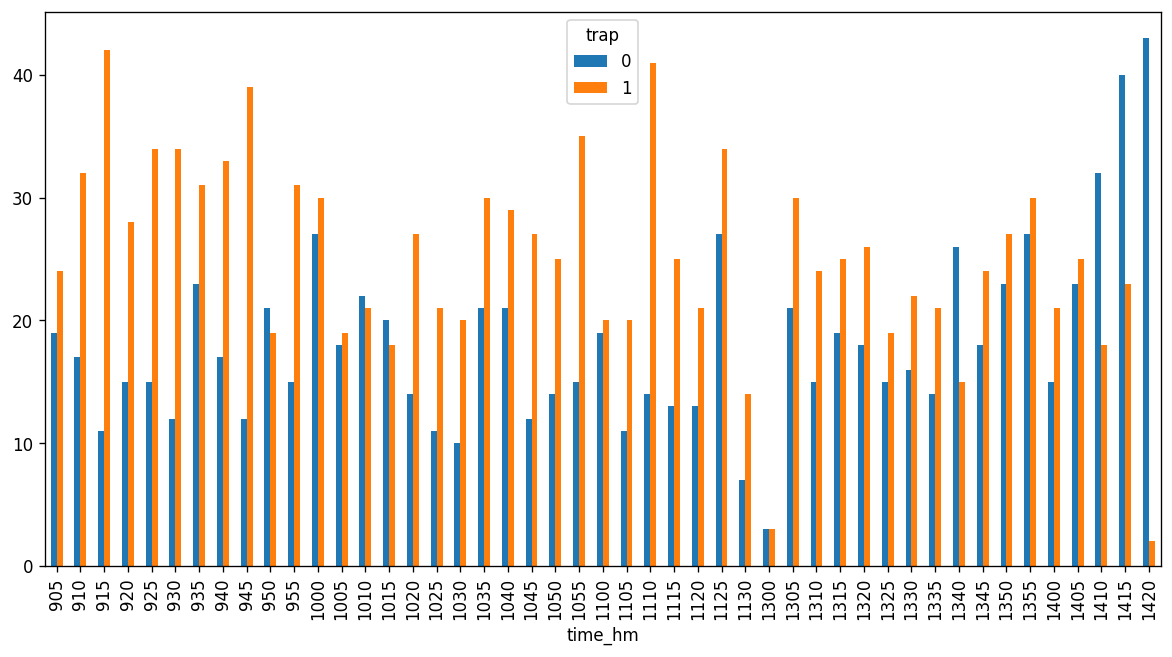

In [95]:
group_by_time_hm = signal_data.groupby(['time_hm', 'trap'])['time_hm'].count().rename({'time_hm': 'count'})
group_by_time_hm.unstack().plot.bar()

<Axes: xlabel='hour'>

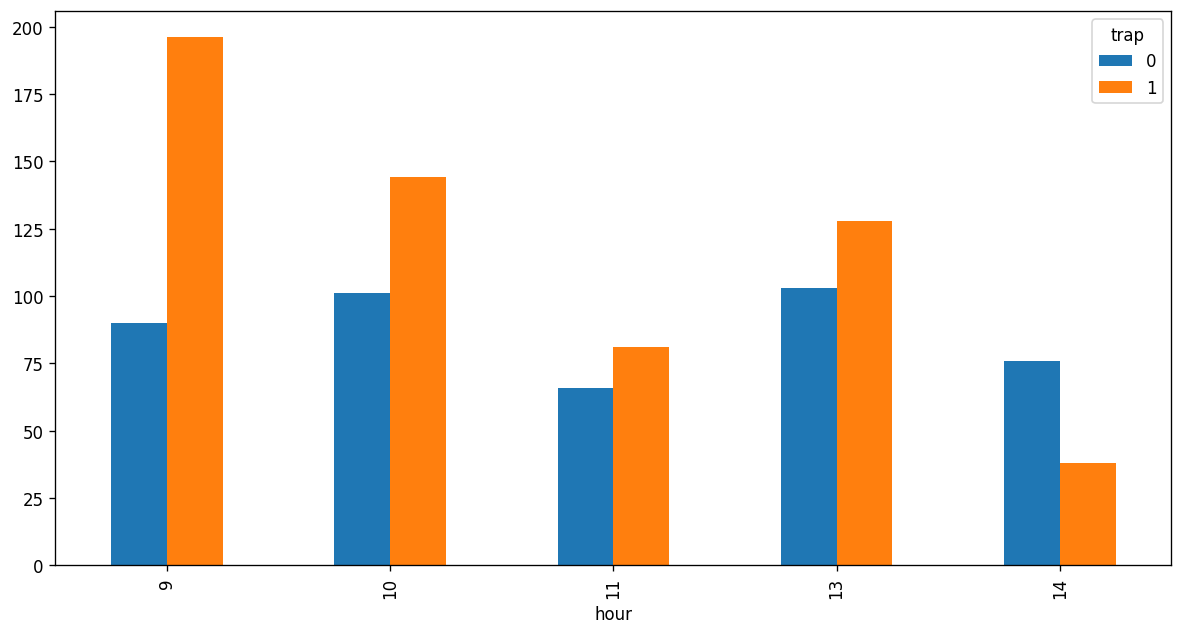

In [96]:
group_by_hour = long_signals.groupby(['hour', 'trap'])['hour'].count().rename({'hour': 'count'})
group_by_hour.unstack().plot.bar()

<Axes: xlabel='minute'>

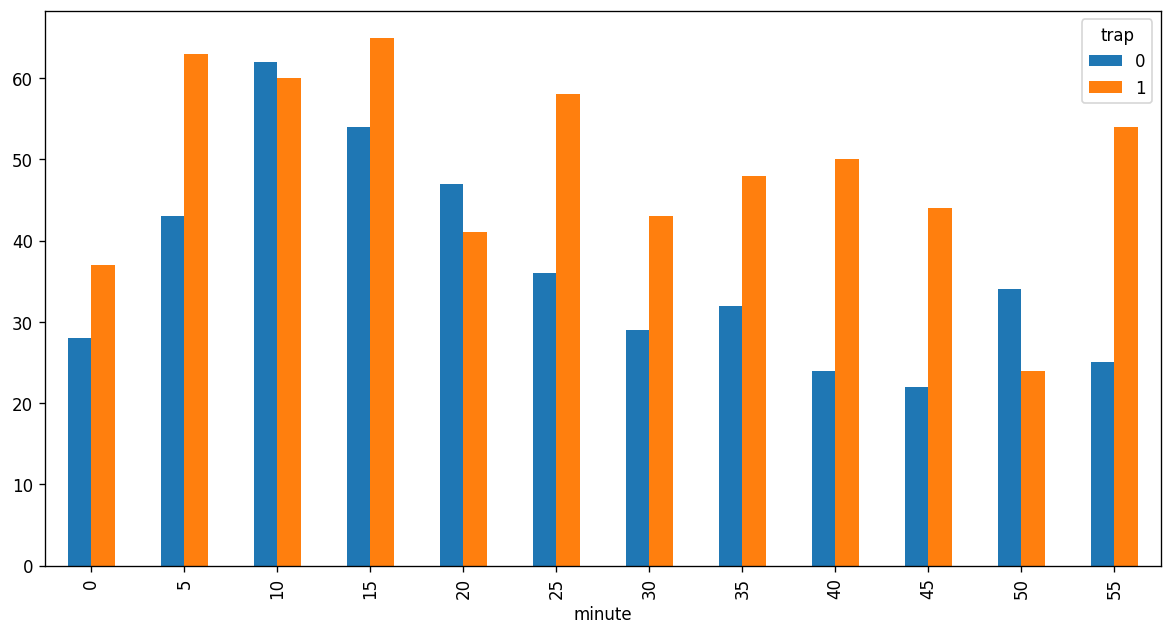

In [97]:
group_by_minute = long_signals.groupby(['minute', 'trap'])['minute'].count().rename({'minute': 'count'})
group_by_minute.unstack().plot.bar()

<Axes: xlabel='day'>

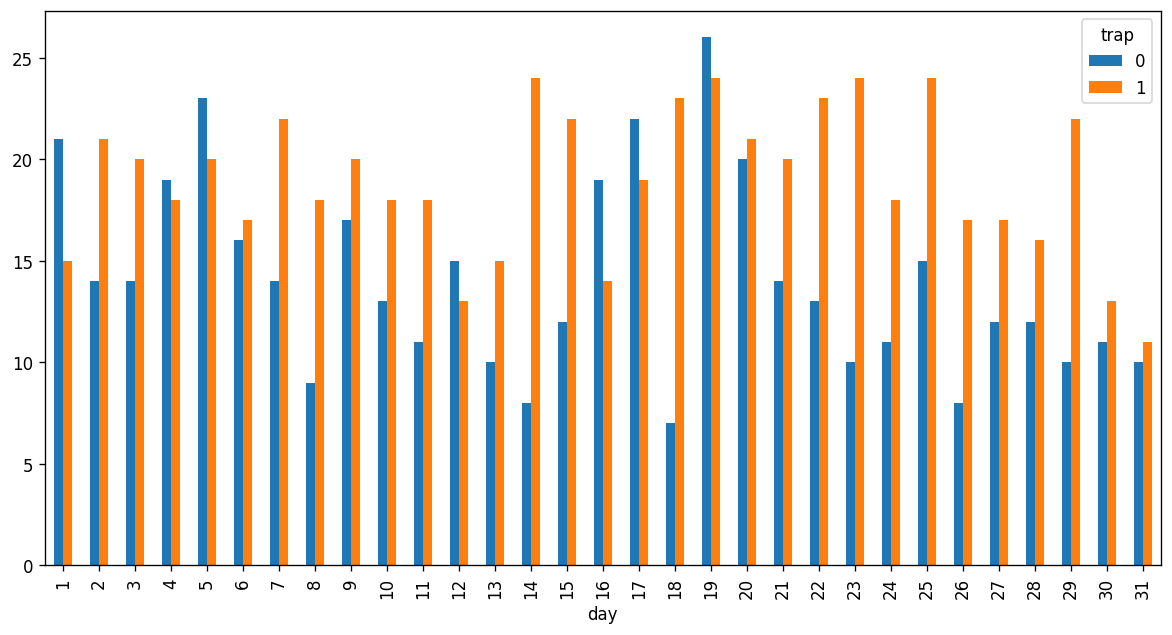

In [98]:
group_by_day = long_signals.groupby(['day', 'trap'])['day'].count().rename({'day': 'count'})
group_by_day.unstack().plot.bar()

<Axes: xlabel='month'>

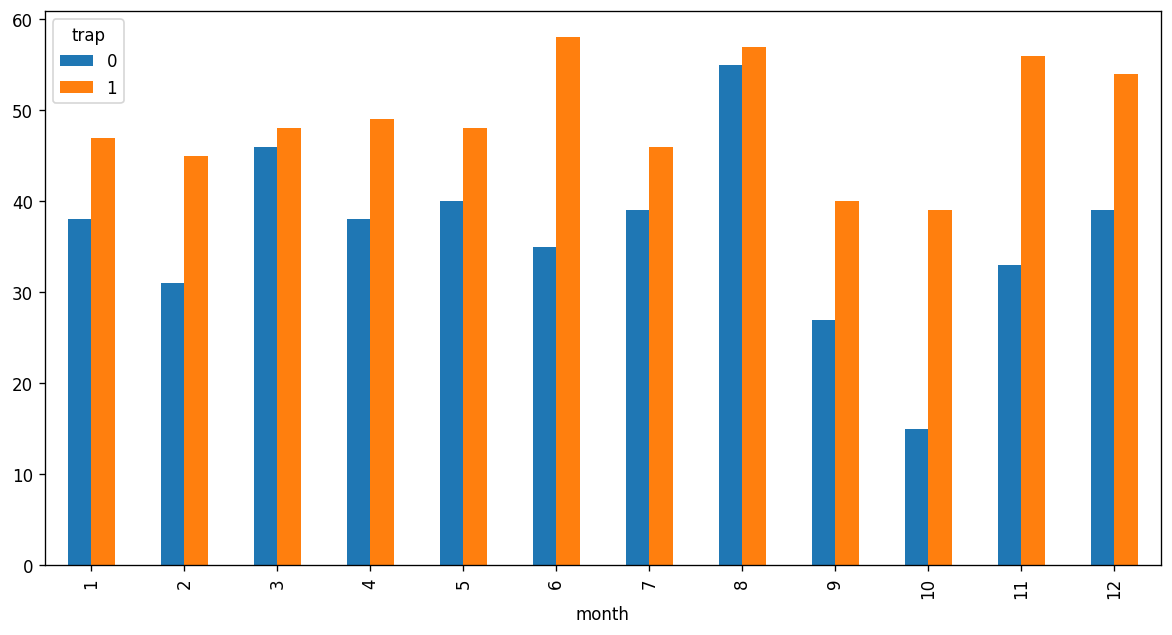

In [99]:
group_by_month = long_signals.groupby(['month', 'trap'])['month'].count().rename({'month': 'count'})
group_by_month.unstack().plot.bar()

<Axes: xlabel='year'>

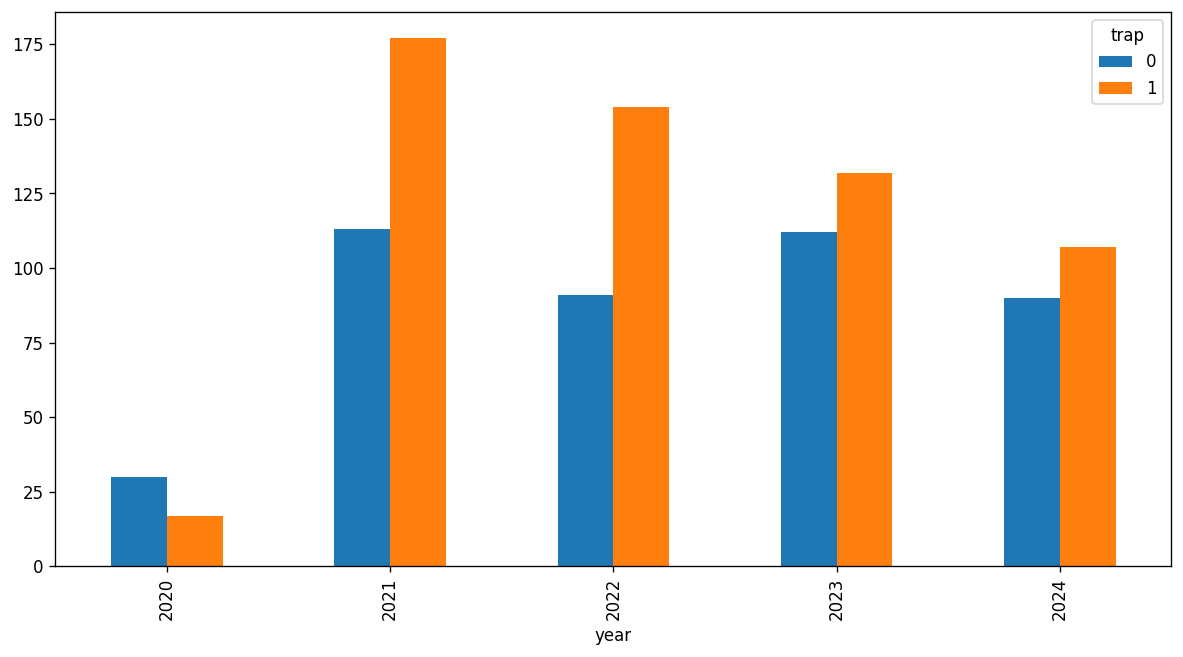

In [100]:
group_by_year = long_signals.groupby(['year', 'trap'])['year'].count().rename({'year': 'count'})
group_by_year.unstack().plot.bar()

<Axes: xlabel='dow'>

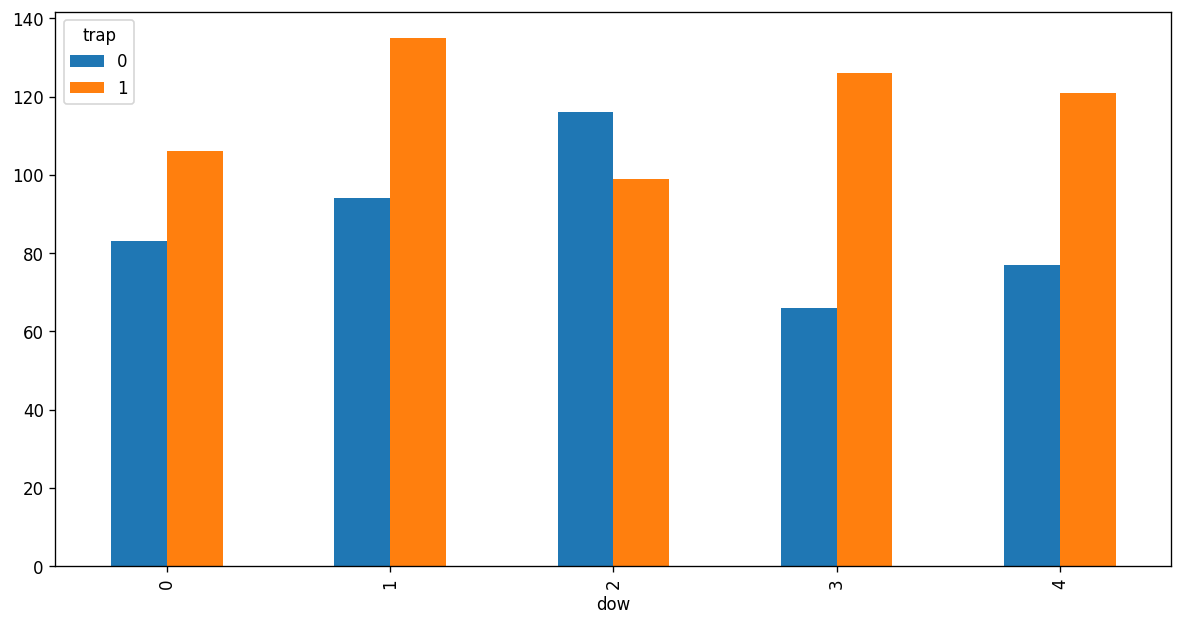

In [101]:
group_by_dow = long_signals.groupby(['dow', 'trap'])['dow'].count().rename({'dow': 'count'})
group_by_dow.unstack().plot.bar()